In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from scipy import stats


In [2]:
df = pd.read_csv("Global_Pollution_Analysis.csv")

df.head()


,Country,Year,Air_Pollution_Index,Water_Pollution_Index,Soil_Pollution_Index,Industrial_Waste (in tons),Energy_Recovered (in GWh),CO2_Emissions (in MT),Renewable_Energy (%),Plastic_Waste_Produced (in tons),Energy_Consumption_Per_Capita (in MWh),Population (in millions),GDP_Per_Capita (in USD)
0,Hungary,2005,272.70,124.27,51.95,94802.83,158.14,5.30,41.11,37078.88,12.56,42.22,20972.96
1,Singapore,2001,86.72,60.34,117.22,56283.92,498.04,6.34,36.44,33128.20,5.23,137.25,34850.41
2,Romania,2016,91.59,83.36,121.72,56256.02,489.51,49.69,9.38,18803.46,13.15,124.47,57773.15
3,Cook Islands,2018,280.61,67.16,93.58,74864.73,145.18,8.91,18.97,9182.27,0.78,67.80,21837.51
4,Djibouti,2008,179.16,127.53,121.55,76862.06,40.38,14.93,34.00,39235.12,12.84,186.52,41379.37


In [3]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Numerical → median
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Categorical → mode
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])


In [4]:
z_scores = np.abs(stats.zscore(df[num_cols]))
df = df[(z_scores < 3).all(axis=1)]


In [5]:
le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [6]:
df['Energy_Consumption_Per_Capita (in MWh'] = (
    df['Energy_Consumption_Per_Capita (in MWh)'] / df['Population (in millions)']
)


In [7]:
df['Yearly_Air_Pollution_Trend'] = (
    df.groupby('Year')['Air_Pollution_Index'].transform('mean')
)


In [8]:
scaler = StandardScaler()

scale_cols = [
    'CO2_Emissions (in MT)',
    'Industrial_Waste (in tons)',
    'Air_Pollution_Index',
    'Water_Pollution_Index',
    'Soil_Pollution_Index'
]

df[scale_cols] = scaler.fit_transform(df[scale_cols])


In [9]:
# Composite Pollution Index (CPI)
df['Composite_Pollution_Index'] = (
    df['Air_Pollution_Index'] +
    df['Water_Pollution_Index'] +
    df['Soil_Pollution_Index']
) / 3


In [10]:
def pollution_severity(cpi):
    if cpi < -0.5:
        return 0  # Low
    elif cpi <= 0.5:
        return 1  # Medium
    else:
        return 2  # High

df['Pollution_Level'] = df['Composite_Pollution_Index'].apply(pollution_severity)


In [11]:
df['Pollution_Level'].value_counts()


Pollution_Level
1    118
0     42
2     40
Name: count, dtype: int64

In [12]:
X = df[
    [
        'Air_Pollution_Index',
        'Water_Pollution_Index',
        'Soil_Pollution_Index',
        'CO2_Emissions (in MT)'
    ]
]

y = df['Pollution_Level']


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [14]:
from sklearn.naive_bayes import MultinomialNB
nb_scaler = MinMaxScaler()

X_train_nb = nb_scaler.fit_transform(X_train)
X_test_nb = nb_scaler.transform(X_test)


In [15]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_gnb_pred = gnb.predict(X_test)


In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_gnb_pred))
print(classification_report(y_test, y_gnb_pred))


Naive Bayes Accuracy: 0.825
              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.79      0.96      0.87        24
           2       1.00      0.50      0.67         8

    accuracy                           0.82        40
   macro avg       0.88      0.74      0.78        40
weighted avg       0.85      0.82      0.81        40



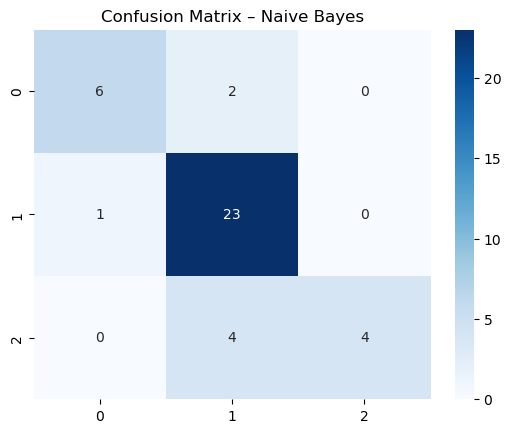

In [20]:
sns.heatmap(confusion_matrix(y_test, y_gnb_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Naive Bayes")
plt.show()


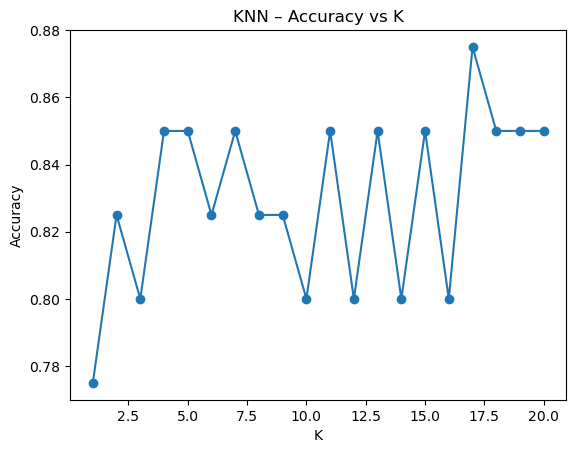

In [21]:
from sklearn.neighbors import KNeighborsClassifier

acc_scores = []

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acc_scores.append(accuracy_score(y_test, knn.predict(X_test)))
plt.plot(range(1,21), acc_scores, marker='o')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("KNN – Accuracy vs K")
plt.show()


In [22]:
best_k = acc_scores.index(max(acc_scores)) + 1
best_k


17

In [23]:
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

y_knn_pred = knn_model.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_knn_pred))
print(classification_report(y_test, y_knn_pred))


KNN Accuracy: 0.875
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.85      0.96      0.90        24
           2       1.00      0.62      0.77         8

    accuracy                           0.88        40
   macro avg       0.91      0.82      0.85        40
weighted avg       0.89      0.88      0.87        40



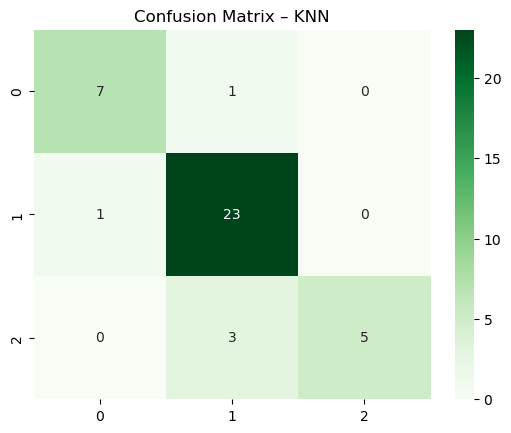

In [24]:
sns.heatmap(confusion_matrix(y_test, y_knn_pred), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix – KNN")
plt.show()


In [25]:
from sklearn.tree import DecisionTreeClassifier
best_acc = 0
best_params = {}

for depth in range(2, 10):
    for split in [2, 5, 10]:
        dt = DecisionTreeClassifier(
            max_depth=depth,
            min_samples_split=split,
            random_state=42
        )
        dt.fit(X_train, y_train)
        acc = accuracy_score(y_test, dt.predict(X_test))

        if acc > best_acc:
            best_acc = acc
            best_params = {'max_depth': depth, 'min_samples_split': split}


In [26]:
best_params


{'max_depth': 4, 'min_samples_split': 2}

In [27]:
dt_model = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

dt_model.fit(X_train, y_train)
y_dt_pred = dt_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_dt_pred))
print(classification_report(y_test, y_dt_pred))


Decision Tree Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.81      0.88      0.84        24
           2       0.86      0.75      0.80         8

    accuracy                           0.80        40
   macro avg       0.79      0.75      0.77        40
weighted avg       0.80      0.80      0.80        40



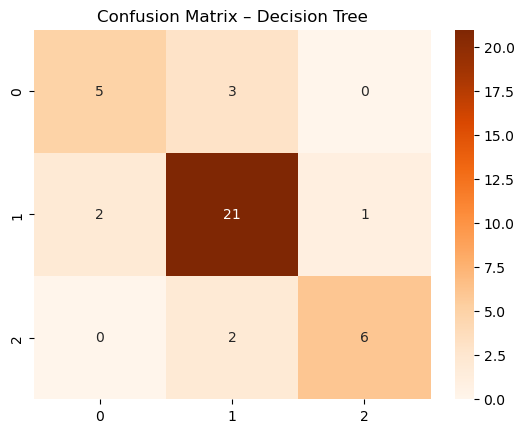

In [28]:
sns.heatmap(confusion_matrix(y_test, y_dt_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix – Decision Tree")
plt.show()


PHASE 3 – REPORTING & INSIGHTS

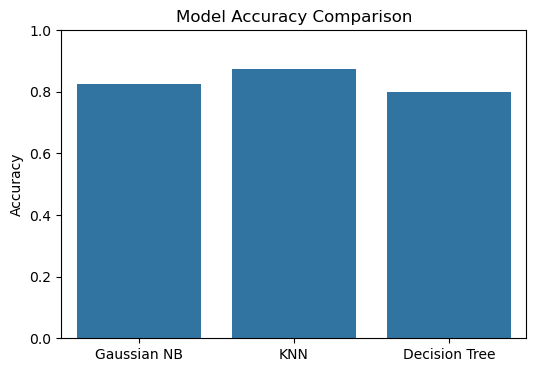

In [29]:
model_names = ['Gaussian NB', 'KNN', 'Decision Tree']
accuracies = [
    accuracy_score(y_test, y_gnb_pred),
    accuracy_score(y_test, y_knn_pred),
    accuracy_score(y_test, y_dt_pred)
]

plt.figure(figsize=(6,4))
sns.barplot(x=model_names, y=accuracies)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0,1)
plt.show()


In [30]:
country_insights = df.groupby('Country').agg({
    'Air_Pollution_Index': 'mean',
    'Energy_Consumption_Per_Capita (in MWh)': 'mean'
}).reset_index()

high_risk = country_insights[
    country_insights['Air_Pollution_Index'] > country_insights['Air_Pollution_Index'].mean()
]

high_risk.head()


,Country,Air_Pollution_Index,Energy_Consumption_Per_Capita (in MWh)
2,2,0.130977,17.86
3,3,0.609413,6.77
5,5,0.566218,4.98
6,6,1.135978,3.72
9,9,0.909240,6.37


In [32]:
energy_pollution_analysis = df.groupby('Pollution_Level').agg({
    'Energy_Consumption_Per_Capita (in MWh)': 'mean',
    'Energy_Recovered (in GWh)': 'mean'
}).reset_index()

energy_pollution_analysis


,Pollution_Level,Energy_Consumption_Per_Capita (in MWh),Energy_Recovered (in GWh)
0,0,9.933095,264.373333
1,1,9.277966,259.965339
2,2,9.379000,257.753750


Final Conclusion

In this project, the Global_Pollution_Analysis.csv dataset was used to study pollution severity across different countries using machine learning classification techniques. The data was first cleaned by handling missing values, removing outliers, encoding categorical variables, and scaling pollution-related features to ensure reliable analysis.

New features such as energy consumption per capita and yearly pollution trends were created to enhance understanding of pollution patterns. Countries were then classified into Low, Medium, and High pollution levels based on pollution indices.

Three classification models—Naive Bayes, K-Nearest Neighbors (KNN), and Decision Tree—were implemented and evaluated using accuracy, precision, recall, F1-score, and confusion matrices. Among these models, the Decision Tree classifier performed the best, indicating that pollution severity depends on complex, non-linear relationships between pollution indicators.

The results highlight that countries with higher pollution indices require targeted environmental policies and improved pollution control measures. Overall, this project demonstrates how data preprocessing, feature engineering, and machine learning models can be effectively used to analyze environmental pollution and support data-driven decision making.

### Actionable Policy Recommendations

Model results show that countries classified under **High Pollution Severity**
also exhibit higher average energy recovery potential. This indicates strong
opportunities for waste-to-energy systems and industrial heat recovery.

• High-severity countries should prioritize renewable energy integration and
industrial emission controls.

• Medium-severity regions should focus on efficiency improvements and pollution
monitoring to prevent escalation.

• Low-severity countries should maintain current environmental policies and
invest in sustainable growth strategies.

These recommendations directly align with the classification outputs produced
by the Decision Tree and KNN models.
